### First architecture: 
As a first architecture, we reshape the data in order to only learn the classes of each image. The comparison of labels is done as a post-processing step. 

In [1]:
import torch
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F

import dlc_practical_prologue as prologue

### Load data 

In [313]:
N = 1000
train_input, train_target_final, train_classes, test_input, test_target_final,test_classes = prologue.generate_pair_sets(N)

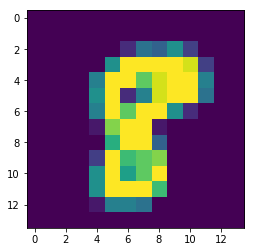

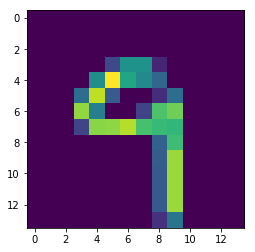

In [314]:
# Show images
import matplotlib.pyplot as plt
img1 = train_input[150][0]
plt.imshow(img1)
plt.show()
img2 = train_input[150][1]
plt.imshow(img2)
plt.show()

### Define one-hot classes

In [315]:
train_binary_classes = torch.full((2*N,10), 0)
test_binary_classes = torch.full((2*N, 10), 0)

In [316]:
test_classes

tensor([[1, 2],
        [4, 7],
        [2, 0],
        ...,
        [8, 9],
        [4, 2],
        [8, 0]])

In [317]:
train_binary_classes.scatter_(1,train_classes.reshape((2*N, 1)), 1)
test_binary_classes.scatter_(1,test_classes.reshape((2*N, 1)), 1)

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

In [318]:
train_classes

tensor([[4, 3],
        [8, 4],
        [4, 4],
        ...,
        [0, 7],
        [2, 3],
        [1, 0]])

In [319]:
train_binary_classes

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

In [320]:
train_input, train_target = Variable(train_input.reshape((2*N, 14*14))), Variable(train_binary_classes)
test_input, test_target = Variable(test_input.reshape((2*N, 14*14))), Variable(test_binary_classes)

### Standardize the data

In [321]:
mu = train_input.mean(dim=0)
std = train_input.std(dim=0)

In [322]:
train_input.sub_(mu).div_(std+1)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [323]:
test_input.sub_(mu).div_(std+1)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

### Functions to train the model

#### Computes error w.r.t classes 

In [324]:
def compute_nb_errors(output, target):
    return (output.argmax(dim=1) != target.argmax(dim=1)).sum().item()

#### Computes error w.r.t final labels

In [373]:
def compute_errors_final(output, target, mini_batch_size):
    output_classes = output.reshape((mini_batch_size//2, 2, 10)).argmax(dim=2)
    target_classes = target.reshape((mini_batch_size//2, 2, 10)).argmax(dim=2)
    final_output = (output_classes[:,0] <= output_classes[:,1])
    final_target = (target_classes[:,0] <= target_classes[:,1])
    return (final_output != final_target).sum().item()

#### Trains the model

In [379]:
def train_model(model, train_input, train_target, test_input,
                test_target, mini_batch_size, n_epochs):
    for e in range(0, n_epochs):
        sum_loss = 0
        sum_error = 0
        sum_error_final = 0
        # We do this with mini-batches
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            train_target_batch = train_target.narrow(0, b, mini_batch_size)
            loss = criterion(output, train_target_batch)
            sum_error += compute_nb_errors(output, train_target_batch)
            sum_error_final += compute_errors_final(output, train_target_batch, mini_batch_size)
            sum_loss = sum_loss + loss.item()/mini_batch_size
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        output_test = model(test_input)
        test_error = compute_nb_errors(output_test, test_target)
        test_error_final = compute_errors_final(output_test, test_target, 2*N)
        print('Epoch: {}, Loss: {}, Training error: {}%, Final training error: {}%, Test error: {}%, Final test error: {}%'.format(e, sum_loss, 50*sum_error/N, 100*sum_error_final/N, 50*test_error/N, 100*test_error_final/N))

### First network: MLP

In [380]:
d = train_input.shape[1]
h1 = 50
h2 = 50
d_out = train_target.shape[1]
VanillaNN = nn.Sequential(
      nn.Linear(d, h1, bias=True),
      nn.ReLU(),
      nn.Linear(h1, h2, bias=True),
      nn.ReLU(),
      nn.Linear(h2, d_out),
      nn.ReLU(),
      )

In [381]:
model, criterion,  = VanillaNN, nn.MSELoss()
eta, mini_batch_size = 1e-3, 10
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
n_epochs = 50

In [382]:
train_model(model, train_input, train_target, test_input,
                test_target, mini_batch_size, n_epochs)

Epoch: 0, Loss: 1.1728485787287355, Training error: 44.15%, Final training error: 32.4%, Test error: 23.5%, Final test error: 16.9%
Epoch: 1, Loss: 0.5993293129373343, Training error: 20.4%, Final training error: 17.8%, Test error: 19.85%, Final test error: 15.6%
Epoch: 2, Loss: 0.48938944779802107, Training error: 16.9%, Final training error: 17.7%, Test error: 18.75%, Final test error: 16.6%
Epoch: 3, Loss: 0.4338964767521247, Training error: 15.4%, Final training error: 17.7%, Test error: 18.5%, Final test error: 17.4%
Epoch: 4, Loss: 0.3979239367530681, Training error: 14.7%, Final training error: 18.0%, Test error: 18.25%, Final test error: 17.9%
Epoch: 5, Loss: 0.3722837530891409, Training error: 14.15%, Final training error: 18.2%, Test error: 18.35%, Final test error: 18.2%
Epoch: 6, Loss: 0.35315296959015546, Training error: 13.9%, Final training error: 18.2%, Test error: 18.1%, Final test error: 18.8%
Epoch: 7, Loss: 0.33779655590769836, Training error: 13.55%, Final training

### Second network: modified LeNet

In [383]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.fc1 = nn.Linear(64, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2))
        x = F.relu(self.fc1(x.view(-1, 64)))
        x = self.fc2(x)
        return x

In [384]:
train_input, train_target = Variable(train_input.reshape((2*N,1, 14, 14))), Variable(train_binary_classes)
test_input, test_target = Variable(test_input.reshape((2*N,1, 14, 14))), Variable(test_binary_classes)
model, criterion = Net(), nn.MSELoss()
eta, mini_batch_size = 1e-3, 10
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

In [386]:
n_epochs = 50
train_model(model, train_input, train_target, test_input, test_target, mini_batch_size, n_epochs)

Epoch: 0, Loss: 1.5768529273569583, Training error: 57.75%, Final training error: 31.1%, Test error: 34.85%, Final test error: 22.1%
Epoch: 1, Loss: 1.0585370991379022, Training error: 26.85%, Final training error: 18.9%, Test error: 21.55%, Final test error: 15.0%
Epoch: 2, Loss: 0.8503349618986253, Training error: 16.8%, Final training error: 12.4%, Test error: 13.6%, Final test error: 9.9%
Epoch: 3, Loss: 0.7174142535775898, Training error: 11.35%, Final training error: 9.0%, Test error: 11.1%, Final test error: 8.2%
Epoch: 4, Loss: 0.6204348554834721, Training error: 8.4%, Final training error: 7.1%, Test error: 8.95%, Final test error: 7.0%
Epoch: 5, Loss: 0.5518281117081643, Training error: 7.2%, Final training error: 5.4%, Test error: 7.55%, Final test error: 6.4%
Epoch: 6, Loss: 0.5009293010458349, Training error: 6.2%, Final training error: 4.6%, Test error: 7.0%, Final test error: 5.8%
Epoch: 7, Loss: 0.46081911269575376, Training error: 5.3%, Final training error: 3.9%, Test